# Understanding CaloCalTopoClusters vs CalTopoClusters

The training needs the calorimeter clusters as input - this is probably the most important input into the training algorithm. Hence, we should at least be conscious of any change we are going to make to those inputs.

Main points of discussion below:

* R24 files contain `CaloCalTopoClusters_links`, but the R21 files do not.
* Both R24 and R21 contain `CaloCalTopoClusters`.
* In Run 2 code we used the `jet->rawConstituents()` directly to fetch the clusters.
* If we do that in Run 3, a number of the links are not valid - with some "odd" dependence in `\eta` (see below for comparison plots).
* The messy way of accessing these guys (via double indirection) works. Thanks for Tania and Artur for providing the code!

## Run 2

In run 2 we can find the training cluster code extractions in [DiVertAnalysis](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21) [here](https://gitlab.cern.ch/atlas-phys-exotics-llp-mscrid/fullrun2analysis/DiVertAnalysisR21/-/blob/master/DiVertAnalysis/Root/RegionVarCalculator_calRatio.cxx#L384):

```c++
...
int jetIndex = 0;
for (const auto &jet : *jets_nominal)
  {
    // CalRatio LLP NN variables
    xAOD::JetConstituentVector constits = jet->getConstituents();
    addToVectorBranch(vars, "nn_jet_index", jetIndex);

    // Arrays for fdeep
    double clus_pt_arr[30] = {};
    ...

    // Need counter to stop after 30 constituents
    int constit_counter = 0;

    // add constituents to ntuple, and also for fdeep arrays
    for (const auto &c : constits)
    {

      const xAOD::IParticle *rawObj = c->rawConstituent();
      const xAOD::CaloCluster *cl = dynamic_cast<const xAOD::CaloCluster *>(rawObj);

      addToVectorBranch(vars, "cluster_jetIndex", jetIndex);

      addToVectorBranch(vars, "clus_pt", c->pt());
      if (constit_counter < 30)
        clus_pt_arr[constit_counter] = c->pt();
      ...
    }

    ...

    if (isCleanJet_LooseBadLLP && (jet->pt() > 40000) && (fabs(jet->eta()) < 2.5))
    {
      // pre-process arrays in CalRatioUtils to match training pre-processing in python
      CalRatioUtils::getNNoutput(clus_pt_arr, clus_eta_arr, clus_phi_arr, clus_l1ecal_arr, clus_l2ecal_arr,
                                 clus_l3ecal_arr, clus_l4ecal_arr, clus_l1hcal_arr, clus_l2hcal_arr, clus_l3hcal_arr, clus_l4hcal_arr,
                                 clus_time_arr, track_pt_arr, track_eta_arr, track_phi_arr, track_vertex_nParticles_arr, track_chiSquared_arr,
                                 track_d0_arr, track_z0_arr, track_pixShared_arr, track_sctShared_arr, track_pixHoles_arr, track_sctHoles_arr,
                                 track_pixHits_arr, track_sctHits_arr, jet->eta(), jet->phi(), jet->pt(), mseg_etaPos_arr, mseg_phiPos_arr,
                                 mseg_etaDir_arr, mseg_phiDir_arr, mseg_t0_arr, mseg_chiSquared_arr, inputs, input_sequences,
                                 &clusters, &tracks, &msegs, &jets, false);

      ...
    }

    jetIndex++;
  }
```

Note a few things:

* We loop over `jet->getConstituents()` to get at the constituents.
* We are expecting these are the calo clusters that were used in jet reconstruction.
* I think they are pointing at the CaloClusters in the file.

## What is in this file?

This is a MC file that was generated by Ana. It has a small number of events, and whose location can be found attached to this [indico agenda](https://indico.cern.ch/event/1508676/#1-introduction-and-status-repo).

The output of `xAODCheck.py` looking at only things marked "calo":

```text
========================================================================================================================
 File: /mnt/c/Users/gordo/Code/calratio/sx_training_fetch/DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root
------------------------------------------------------------------------------------------------------------------------
    Memory size        Disk Size       Size/Event  Compression Entries  Name (Type)
------------------------------------------------------------------------------------------------------------------------
      2571.09 kB        136.47 kB     0.02 kB/event   18.84      8083   ElectronCaloRings (DataVector<xAOD::CaloRings_v1>) [egamma]
      5442.76 kB       2215.29 kB     0.27 kB/event    2.46      8083   LCOriginTopoClusters (DataVector<xAOD::CaloCluster_v1>) [*Unknown*]
      5742.06 kB       2892.18 kB     0.36 kB/event    1.99      8083   LRTegammaClusters (DataVector<xAOD::CaloCluster_v1>) [*Unknown*]
      6414.43 kB       3076.06 kB     0.38 kB/event    2.09      8083   EMOriginTopoClusters (DataVector<xAOD::CaloCluster_v1>) [*Unknown*]
     33919.52 kB      15700.23 kB     1.94 kB/event    2.16      8083   CaloCalTopoClusters (DataVector<xAOD::CaloCluster_v1>) [CaloTopo]
     70043.17 kB      38437.98 kB     4.76 kB/event    1.82      8083   egammaClusters (DataVector<xAOD::CaloCluster_v1>) [egamma]
    153289.64 kB      82079.03 kB    10.15 kB/event    1.87      8083   CaloCalTopoClusters_links (CaloClusterCellLinkContainer_p1) [CaloTopo]
```

Here is what the output looks like from mc21, a Run2 EXOT15 file:

```text
========================================================================================================================
 File: /mnt/c/Users/gordo/Code/atlas/data/DAOD_EXOT15.26710496._000008.pool.root.1
------------------------------------------------------------------------------------------------------------------------
    Memory size        Disk Size       Size/Event  Compression Entries  Name (Type)
------------------------------------------------------------------------------------------------------------------------
     33070.96 kB      11137.01 kB     1.11 kB/event    2.97     10000   HLT_xAOD__CaloClusterContainer_TrigEFCaloCalibFex (DataVector<xAOD::CaloCluster_v1>) [Trig]
     32690.71 kB      17132.69 kB     1.71 kB/event    1.91     10000   egammaClusters (DataVector<xAOD::CaloCluster_v1>) [egamma]
     46573.35 kB      32145.00 kB     3.21 kB/event    1.45     10000   LCOriginTopoClusters (DataVector<xAOD::CaloCluster_v1>) [*Unknown*]
     61818.78 kB      46031.00 kB     4.60 kB/event    1.34     10000   EMOriginTopoClusters (DataVector<xAOD::CaloCluster_v1>) [*Unknown*]
    507413.49 kB     208007.18 kB    20.80 kB/event    2.44     10000   CaloCalTopoClusters (DataVector<xAOD::CaloCluster_v1>) [CaloTopo]
```

In short - the same stuff is in this file, except there are no links - those exist in the modern files, but not in these files.

## Accessing the Clusters from the Jet Objects

Lets look at the cluster links attached to the jets themselves, especially in in light of the [info from the CaloRing and other people's code](https://codimd.web.cern.ch/C-Be_jRLSZSiydqJR7mr7g).

### Using `constituentLinks`

First, a quick look at the number of clusters attached to each jet

In [1]:
from calratio_training_data import fetch_training_data, build_preselection, run_query
import hist
from hist import Hist
import mplhep
import matplotlib.pyplot as plt
import awkward as ak

In [2]:
# Assume we are in the local directory of the notebook
ds_name = "../DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root"

# Turn the data into a list of jets.
full_data = fetch_training_data(ds_name)
each_jet = build_preselection().SelectMany(lambda e: e.jets)

# Get some cluster info that won't cause a crash!
jet_cluster_info_query = each_jet.Select(lambda j: {
    'pt': j.pt()/1000.0,
    'eta': j.eta(),
    'phi': j.phi(),
    'n_all_clusters': len(j.constituentLinks()),
    'n_valid_clusters': len([lnk for lnk in j.constituentLinks() if lnk.isValid()])
})

jet_cluster_info = run_query(ds_name, jet_cluster_info_query)

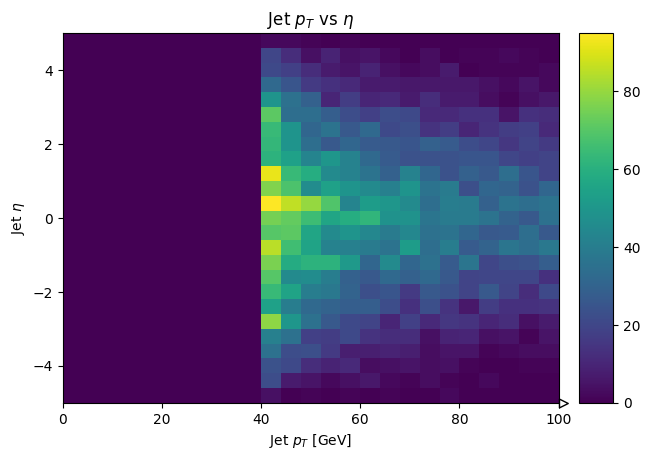

In [3]:
# Create a 2D histogram for jet pt and eta
h = Hist.new.Reg(25, 0, 100, name="pt", label=r"Jet $p_T$ [GeV]") \
          .Reg(25, -5, 5, name="eta", label=r"Jet $\eta$") \
          .Double()

# Fill the histogram with the jet_cluster_info data
h.fill(pt=jet_cluster_info['pt'], eta=jet_cluster_info['eta'])

# Plot the histogram
mplhep.hist2dplot(h, cmap="viridis")
plt.title(r"Jet $p_T$ vs $\eta$")
plt.show()

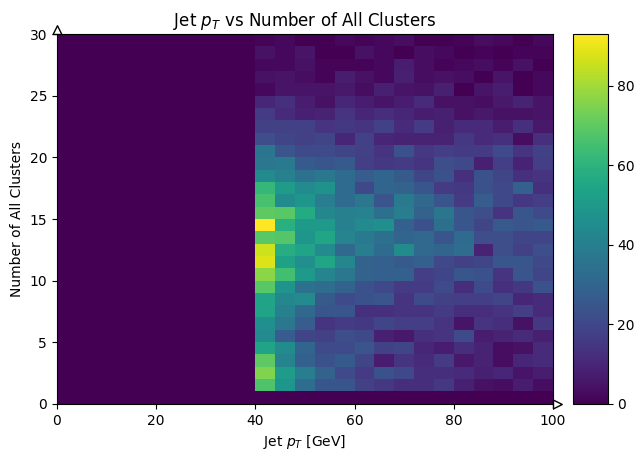

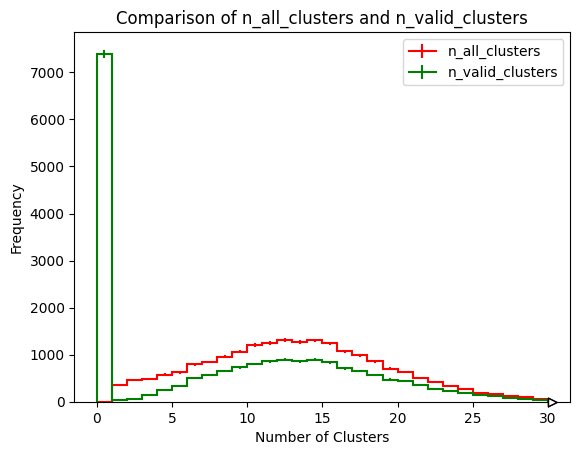

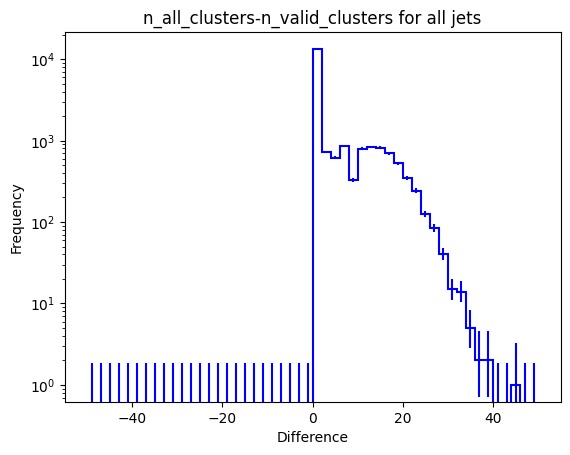

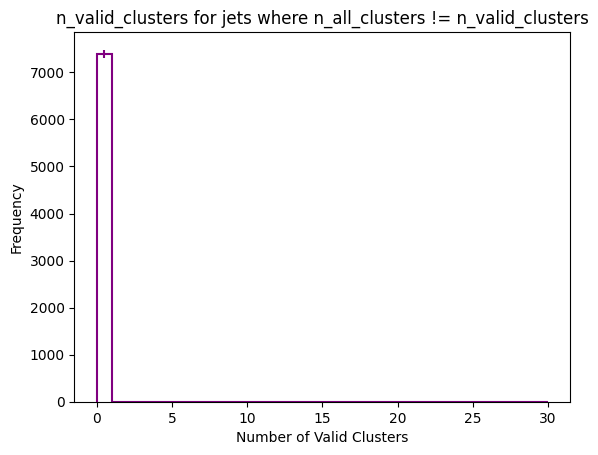

In [4]:
# Create a 2D histogram for jet pt and n_all_clusters
h_pt_n_all_clusters = (
    Hist.new.Reg(25, 0, 100, name="pt", label=r"Jet $p_T$ [GeV]")
    .Reg(30, 0, 30, name="n_all_clusters", label="Number of All Clusters")
    .Double()
)

# Fill the histogram with the jet_cluster_info data
h_pt_n_all_clusters.fill(
    pt=jet_cluster_info["pt"], n_all_clusters=jet_cluster_info["n_all_clusters"]
)

# Plot the histogram
mplhep.hist2dplot(h_pt_n_all_clusters, cmap="viridis")
plt.title(r"Jet $p_T$ vs Number of All Clusters")
plt.show()

# Create histograms for n_all_clusters and n_valid_clusters
h_n_all_clusters = Hist.new.Reg(
    30, 0, 30, name="n_all_clusters", label="Number of All Clusters"
).Double()
h_n_valid_clusters = Hist.new.Reg(
    30, 0, 30, name="n_valid_clusters", label="Number of Valid Clusters"
).Double()

# Fill the histograms with the respective data
h_n_all_clusters.fill(n_all_clusters=jet_cluster_info["n_all_clusters"])
h_n_valid_clusters.fill(n_valid_clusters=jet_cluster_info["n_valid_clusters"])

# Plot the histograms on the same plot
plt.figure()
mplhep.histplot(h_n_all_clusters, histtype="step", color="red", label="n_all_clusters")
mplhep.histplot(
    h_n_valid_clusters, histtype="step", color="green", label="n_valid_clusters"
)
plt.title("Comparison of n_all_clusters and n_valid_clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Frequency")
plt.legend()
plt.show()

def plot_cluster_difference(n_all_clusters, n_valid_clusters, title):
    """
    Plots the difference between n_all_clusters and n_valid_clusters.

    Parameters:
    n_all_clusters (array-like): Array of all clusters.
    n_valid_clusters (array-like): Array of valid clusters.
    title (str): Title for the plot.
    """
    # Calculate the difference between n_all_clusters and n_valid_clusters
    n_cluster_diff = n_all_clusters - n_valid_clusters

    # Create a histogram for the difference
    h_cluster_diff = Hist.new.Reg(
        50, -50, 50, name="diff", label="Difference (n_all_clusters - n_valid_clusters)"
    ).Double()

    # Fill the histogram with the difference data
    h_cluster_diff.fill(diff=n_cluster_diff)

    # Plot the histogram
    mplhep.histplot(h_cluster_diff, histtype="step", color="blue")
    plt.title(title)
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.show()

# Call the method with the appropriate arguments
plot_cluster_difference(
    jet_cluster_info["n_all_clusters"],
    jet_cluster_info["n_valid_clusters"],
    "n_all_clusters-n_valid_clusters for all jets",
)

# Filter jets where n_all_clusters and n_valid_clusters are different
filtered_n_valid_clusters = jet_cluster_info[jet_cluster_info["n_all_clusters"] != jet_cluster_info["n_valid_clusters"]]["n_valid_clusters"]

# Create a histogram for n_valid_clusters of filtered jets
h_filtered_n_valid_clusters = Hist.new.Reg(
    30, 0, 30, name="n_valid_clusters", label="Number of Valid Clusters"
).Double()

# Fill the histogram with the filtered data
h_filtered_n_valid_clusters.fill(n_valid_clusters=filtered_n_valid_clusters)

# Plot the histogram
mplhep.histplot(h_filtered_n_valid_clusters, histtype="step", color="purple")
plt.title("n_valid_clusters for jets where n_all_clusters != n_valid_clusters")
plt.xlabel("Number of Valid Clusters")
plt.ylabel("Frequency")
plt.show()

* I'm a little surprised that the number of clusters doesn't scale with $p_T$ - it looks like it regresses towards a mean of 15! Of course, we aren't looking at very high jet $p_T$'s here, so not sure that means anything.
* If a jet is missing a cluster, then it is missing all of its clusters links.

Lets do a quick check to see if there is an obvious kinematic dependency here.

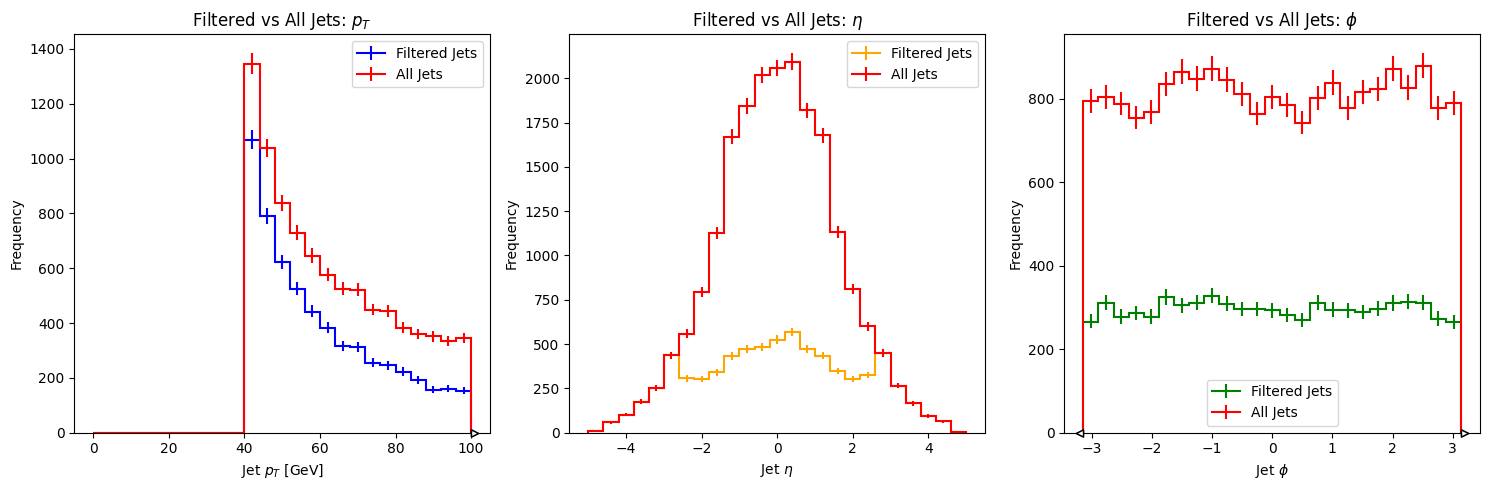

In [5]:
# Create filtered histograms
h_pt_filtered = Hist.new.Reg(25, 0, 100, name="pt", label=r"Jet $p_T$ [GeV]").Double()
h_eta_filtered = Hist.new.Reg(25, -5, 5, name="eta", label=r"Jet $\eta$").Double()
h_phi_filtered = Hist.new.Reg(25, -3.14, 3.14, name="phi", label=r"Jet $\phi$").Double()

# Calc filtered content
filtered_clusters = jet_cluster_info[
    jet_cluster_info["n_all_clusters"] != jet_cluster_info["n_valid_clusters"]
]

# Fill the histograms with the filtered data
h_eta_filtered.fill(eta=filtered_clusters["eta"])
h_phi_filtered.fill(phi=filtered_clusters["phi"])
h_pt_filtered.fill(pt=filtered_clusters["pt"])

# Overlay jet_cluster_info on each histogram for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
mplhep.histplot(h_pt_filtered, histtype="step", color="blue", label="Filtered Jets")
h_pt_all = Hist.new.Reg(25, 0, 100, name="pt", label=r"Jet $p_T$ [GeV]").Double()
h_pt_all.fill(pt=jet_cluster_info["pt"])
mplhep.histplot(h_pt_all, histtype="step", color="red", label="All Jets")
plt.title(r"Filtered vs All Jets: $p_T$")
plt.xlabel(r"Jet $p_T$ [GeV]")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 2)
mplhep.histplot(h_eta_filtered, histtype="step", color="orange", label="Filtered Jets")
h_eta_all = Hist.new.Reg(25, -5, 5, name="eta", label=r"Jet $\eta$").Double()
h_eta_all.fill(eta=jet_cluster_info["eta"])
mplhep.histplot(h_eta_all, histtype="step", color="red", label="All Jets")
plt.title(r"Filtered vs All Jets: $\eta$")
plt.xlabel(r"Jet $\eta$")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
mplhep.histplot(h_phi_filtered, histtype="step", color="green", label="Filtered Jets")
h_phi_all = Hist.new.Reg(25, -3.14, 3.14, name="phi", label=r"Jet $\phi$").Double()
h_phi_all.fill(phi=jet_cluster_info["phi"])
mplhep.histplot(h_phi_all, histtype="step", color="red", label="All Jets")
plt.title(r"Filtered vs All Jets: $\phi$")
plt.xlabel(r"Jet $\phi$")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

* So there is some odd dependency here in $\eta$. Maybe some jet cleaning variable? From these plots not likely to be able to tell why. Need to add LLP good or similar, I suspect.

The real question - can we get at the cluster eta, phi, etc.? This was causing the trouble last time, though I do not think we were checking the validity of the links.

The following code:

```python
jet_cluster_info_query = each_jet.Select(
    lambda j: {
        "pt": j.pt() / 1000.0,
        "eta": j.eta(),
        "phi": j.phi(),
        "n_valid_clusters": len([lnk for lnk in j.constituentLinks() if lnk.isValid()]),
        "clust_pt": [lnk.pt() for lnk in j.constituentLinks() if lnk.isValid()],
    }
)

jet_cluster_info = run_query(ds_name, jet_cluster_info_query)
```

still makes the error that we've been seeing - despite the `isValid` protection:

```text
INFO:servicex_local.science_images:Package.EventLoop        ERROR   /build1/atnight/localbuilds/nightlies/AnalysisBase/main/athena/PhysicsAnalysis/D3PDTools/EventLoop/Root/MessageCheck.cxx:37 (void EL::Detail::report_exception(std::__exception_ptr::exception_ptr)): caught exception: SG::ExcBadAuxVar: Attempt to retrieve nonexistent aux data item `::calM' (710).
```

We can run it, but the error messages are typical of an EventLoop job - 100's of lines, with only one important one. :-)

### Using the CaloRing/Trigger way of accessing things

To reuse the code from Tania and Artur, need to inject some C++ into ServiceX, so this is going to look a little weird.

In [6]:
import ast
from typing import Tuple, TypeVar

from func_adl import ObjectStream, func_adl_callable
from func_adl_servicex_xaodr25.elementlink_datavector_xaod_iparticle__ import (
    ElementLink_DataVector_xAOD_IParticle__,
)
from func_adl_servicex_xaodr25.xAOD.calocluster_v1 import CaloCluster_v1

T = TypeVar("T")


def cvt_to_raw_calocluster_callback(
    s: ObjectStream[T], a: ast.Call
) -> Tuple[ObjectStream[T], ast.Call]:
    """Use dynamic cast to convert

    Args:
        s (ObjectStream[T]): The stream we are operating against
        a (ast.Call): The actual call

    Returns:
        Tuple[ObjectStream[T], ast.Call]: Return the updated stream with the metadata code.
    """
    new_s = s.MetaData(
        {
            "metadata_type": "add_cpp_function",
            "name": "cvt_to_raw_calocluster",
            "code": [
                "// Very ugly!\n",
                "const xAOD::CaloCluster* clus = dynamic_cast<const xAOD::CaloCluster*>(*link);\n",
                'const SG::AuxElement::ConstAccessor< ElementLink<xAOD::IParticleContainer> > originalObject("originalObjectLink");\n',
                "const xAOD::CaloCluster* result = dynamic_cast<const xAOD::CaloCluster*>(*originalObject(*clus));\n",
            ],
            "result": "result",
            "include_files": ["xAODCaloEvent/CaloCluster.h"],
            "arguments": ["link"],
            "return_type": "const xAOD::CaloCluster_v1*",
        }
    )

    return new_s, a


@func_adl_callable(cvt_to_raw_calocluster_callback)
def cvt_to_raw_calocluster(
    link: ElementLink_DataVector_xAOD_IParticle__,
) -> CaloCluster_v1:
    """
    Converts a given link to a cluster to a CaloCluster_v1 object.

    Args:
        link (ElementLink_DataVector_xAOD_IParticle__): The input cluster link to be converted.

    Returns:
        CaloCluster_v1: The converted CaloCluster_v1 object.
    """
    ...

In [7]:
# And the query
jet_cluster_kinematics_query = each_jet.Select(
    lambda j: {
        "pt": j.pt() / 1000.0,
        "eta": j.eta(),
        "phi": j.phi(),
        "n_valid_clusters": len([lnk for lnk in j.constituentLinks() if lnk.isValid()]),
        "clust_pt": [cvt_to_raw_calocluster(lnk).pt()/1000.0 for lnk in j.constituentLinks() if lnk.isValid()],
    }
)

jet_kinematics_info = run_query(ds_name, jet_cluster_kinematics_query)

DEBUG:servicex_local.science_images:Running command: docker run --name sx_codegen_container_sslhep_servicex_func_adl_xaod_transformer_25.2.41_DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool --rm -v C:\Users\gordo\AppData\Local\Temp\tmpkscotsqb:/generated -v C:\Users\gordo\AppData\Local\Temp\servicex\a438ba40-5849-4a80-9a95-fa1797211d6b:/servicex/output -v c:\Users\gordo\Code\calratio\sx_training_fetch\notebooks\..\DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root:/input_file.root sslhep/servicex_func_adl_xaod_transformer:25.2.41 bash /generated/file_runner.sh /input_file.root /servicex/output/DAOD_LLP1.outputLLP1_mc23_537565_trigger.pool.root root_ttree
DEBUG:servicex_local.science_images:Compile
DEBUG:servicex_local.science_images:Configured GCC from: /opt/lcg/gcc/13.1.0-b3d18/x86_64-el9/bin/gcc
DEBUG:servicex_local.science_images:Configured AnalysisBase from: /usr/AnalysisBase/25.2.41/InstallArea/x86_64-el9-gcc13-opt
DEBUG:servicex_local.science_images:call.  Please see the cmake-comm

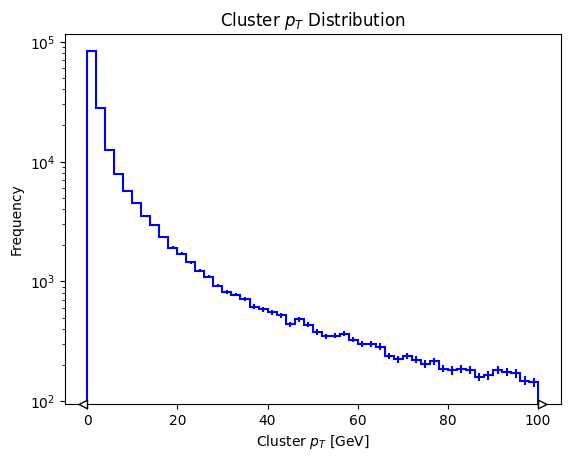

In [8]:
# Extract clust_pt from jet_kinematics_info and flatten the nested array
clust_pt = ak.flatten(jet_kinematics_info["clust_pt"])

# Create a histogram for clust_pt
h_clust_pt = Hist.new.Reg(50, 0, 100, name="clust_pt", label="Cluster $p_T$ [GeV]").Double()

# Fill the histogram with the clust_pt data
h_clust_pt.fill(clust_pt=clust_pt)

# Plot the histogram
mplhep.histplot(h_clust_pt, histtype="step", color="blue")
plt.title("Cluster $p_T$ Distribution")
plt.xlabel("Cluster $p_T$ [GeV]")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

So the super ugly way of accessing these guys works! So weird that this is the case! :-(